# A test on quantile-based CUSUM

In [107]:
import numpy as np
import matplotlib.pyplot as plt

In [108]:
def quantile_loss(target, q_pred, q_level):
    errors = target - q_pred
    loss = np.max([((q_level -1)*errors).reshape(-1,1), (q_level*errors).reshape(-1,1)], axis=0)
    return loss

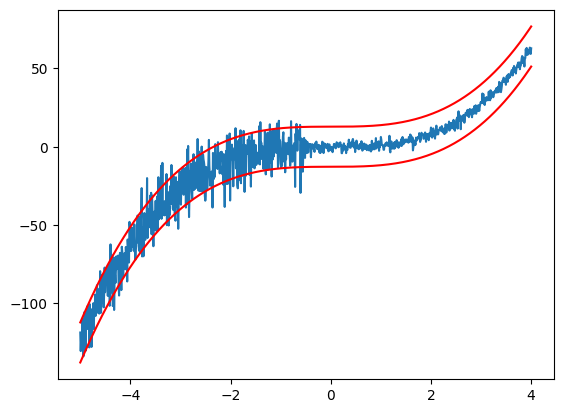

In [109]:
# Generate noisy data
x = np.linspace(-5, 4, 1000).reshape(-1,1)
y_true = (x**3).reshape(-1,1)
y_noisy = y_true + np.random.normal(0, 10, size=x.shape)

# increase noise
# y_noisy[500:] = y_noisy[500:] + np.random.normal(0,20, size=x[500:].shape)

# reduce noise
y_noisy[500:] = y_true[500:] + np.random.normal(0,2, size=x[500:].shape)

plt.plot(x,y_noisy)

# Assume this is our 0.9 quantile prediction
y_q_pred_ub = x**3 + 12.8
y_q_pred_lb = x**3 - 12.8

plt.plot(x, y_q_pred_ub, label='Quantile Prediction', color='red')
plt.plot(x, y_q_pred_lb, color='red')

# quantile loss
q_level_ub = 0.9
loss_1 = quantile_loss(y_noisy, y_q_pred_ub, q_level_ub)
q_level_lb = 0.1
loss_2 = quantile_loss(y_noisy, y_q_pred_lb, q_level_lb)




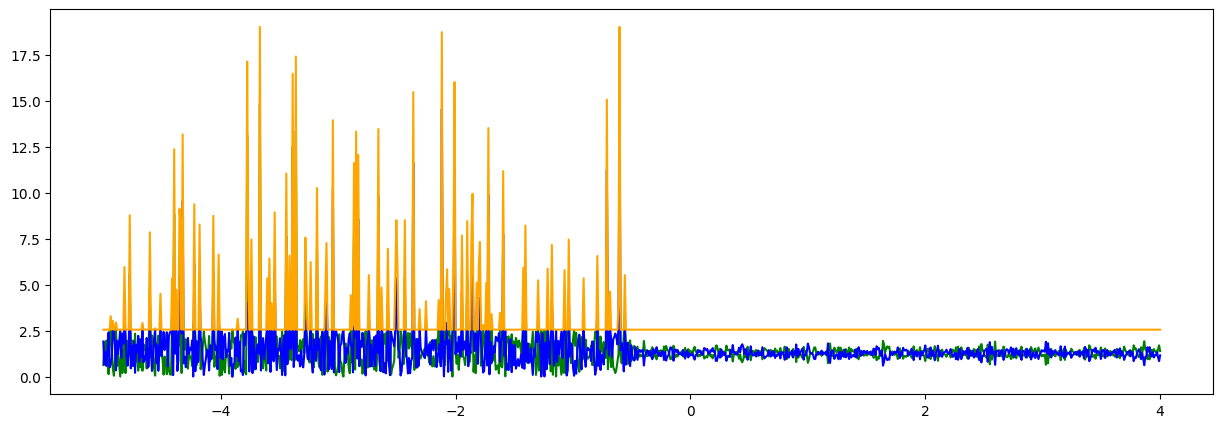

In [110]:
fig = plt.figure(figsize=(15, 5))
plt.plot(x, loss_1, label='Quantile Loss', color='green')
plt.plot(x, loss_2, label='Quantile Loss (Upper)', color='blue')
plt.plot(x, loss_1 + loss_2, label='Quantile Loss sum', color='orange')

In [111]:
def quantile_log_likelihood(y, q_pred, alpha):
    """
    Computes the log-likelihood under an asymmetric Laplace assumption for quantile regression.
    
    Parameters:
    - y: true observed values (array)
    - q_pred: predicted quantiles (same shape as y)
    - alpha: quantile level (e.g., 0.9)

    Returns:
    - log_likelihood: total log pseudo-likelihood
    """
    assert len(y) == len(q_pred)
    residuals = y - q_pred
    rho = np.where(residuals >= 0, alpha * residuals, (alpha - 1) * residuals)
    log_likelihood = len(y) * np.log(alpha * (1 - alpha)) - np.sum(rho)
    return log_likelihood


In [112]:
def cusum(data, threshold, drift=0):
    """
    CUSUM (Cumulative Sum Control Chart) to detect drift in data.

    Parameters:
    - data: numpy.ndarray, the input data (e.g., loss values).
    - threshold: float, the threshold for detecting a drift.
    - drift: float, the minimum detectable drift (default is 0).

    Returns:
    - drift_points: list, indices where drift is detected.
    """
    g_pos, g_neg = 0, 0  # Positive and negative cumulative sums
    drift_points = []

    for i, value in enumerate(data):
        g_pos = max(0, g_pos + value - drift)
        g_neg = min(0, g_neg + value + drift)

        if g_pos > threshold:
            drift_points.append(i)
            g_pos = 0  # Reset after detecting drift

        if g_neg < -threshold:
            drift_points.append(i)
            g_neg = 0  # Reset after detecting drift

    return drift_points

In [113]:
# drift_ID = cusum(loss, threshold=40, drift=1)
# drift_ID

In [116]:
import numpy as np

class QuantileCUSUM:
    def __init__(self, alpha=0.9, threshold=5.0):
        """
        Initializes the CUSUM drift detector for quantile overestimation.
        
        Parameters:
        - alpha: the quantile level (e.g., 0.9 for the 90% quantile).
        - threshold: detection threshold for the cumulative sum.
        """
        self.alpha = alpha
        self.threshold = threshold
        self.reset()

    def reset(self):
        self.C_t = 0  # CUSUM statistic
        self.drift_detected = False
        self.t = 0  # Time step

    def update(self, y_t, q_t):
        """
        Update the CUSUM statistic with a new observation and predicted quantile.
        
        Parameters:
        - y_t: actual observed value
        - q_t: predicted quantile value
        
        Returns:
        - drift (bool): True if drift is detected, False otherwise.
        - C_t (float): current value of the CUSUM statistic
        """
        I_t = 1.0 if y_t > q_t else 0.0
        s_t = I_t - (1 - self.alpha)
        self.C_t = min(0, self.C_t + s_t)
        self.t += 1

        if self.C_t < -self.threshold:
            self.drift_detected = True
            
            return True, self.C_t  # drift occurred

        return False, self.C_t


# import numpy as np

# class QuantileCUSUMDeviation:
#     def __init__(self, alpha=0.9, threshold=5.0):
#         """
#         Quantile CUSUM detector using signed deviation when y_t <= q_t.
        
#         Parameters:
#         - alpha: target quantile level (e.g., 0.9 for the 90% quantile).
#         - threshold: how negative C_t can go before flagging drift.
#         """
#         self.alpha = alpha
#         self.threshold = threshold
#         self.reset()

#     def reset(self):
#         self.C_t = 0.0
#         self.drift_detected = False
#         self.t = 0

#     def update(self, y_t, q_t):
#         """
#         Update CUSUM with a new observation and quantile prediction.
        
#         Parameters:
#         - y_t: observed value
#         - q_t: predicted quantile value
        
#         Returns:
#         - drift (bool): True if drift is detected
#         - C_t (float): current CUSUM statistic
#         """
#         # Only penalize when y_t is below the quantile (i.e., quantile is too high)
#         if y_t <= q_t:
#             s_t = (y_t - q_t) * self.alpha  # negative deviation weighted
#         else:
#             s_t = 0.0  # no penalty if y_t exceeds q_t

#         self.C_t = min(0.0, self.C_t + s_t)
#         self.t += 1

#         if self.C_t < -self.threshold:
#             self.drift_detected = True
#             self.reset()
#             return True, self.C_t

#         return False, self.C_t

In [117]:
cusum_detector = QuantileCUSUM(alpha=0.9, threshold=5.0)
#cusum_detector = QuantileCUSUMDeviation(alpha=0.9, threshold=1000)
for i in range(len(y_noisy)):
    y_t = y_noisy[i]
    q_t = y_q_pred_ub[i]
    drift, C_t = cusum_detector.update(y_t, q_t)
    if drift:
        print(f"Drift detected at index {i} with CUSUM value {C_t:.2f}")

Drift detected at index 389 with CUSUM value -5.00
Drift detected at index 390 with CUSUM value -5.10
Drift detected at index 391 with CUSUM value -5.20
Drift detected at index 392 with CUSUM value -5.30
Drift detected at index 393 with CUSUM value -5.40
Drift detected at index 394 with CUSUM value -5.50
Drift detected at index 395 with CUSUM value -5.60
Drift detected at index 396 with CUSUM value -5.70
Drift detected at index 409 with CUSUM value -5.00
Drift detected at index 410 with CUSUM value -5.10
Drift detected at index 411 with CUSUM value -5.20
Drift detected at index 412 with CUSUM value -5.30
Drift detected at index 413 with CUSUM value -5.40
Drift detected at index 414 with CUSUM value -5.50
Drift detected at index 415 with CUSUM value -5.60
Drift detected at index 416 with CUSUM value -5.70
Drift detected at index 417 with CUSUM value -5.80
Drift detected at index 418 with CUSUM value -5.90
Drift detected at index 419 with CUSUM value -6.00
Drift detected at index 420 wit